In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from skimage import data, io, color, img_as_ubyte, morphology
from skimage.exposure import histogram
from skimage.filters import threshold_li
import cv2
from scipy import ndimage as ndi
from skimage import feature
import time
from scipy.spatial import distance
import math

warnings.filterwarnings('ignore')

def showImage(image):
    plt.figure(figsize=(100,100))
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()
    
def import_image(img):
    path = 'images/'
    image = io.imread(path + img)
    image_gray = color.rgb2gray(image)

    image_byte = img_as_ubyte(image_gray)
    image_blur = cv2.blur(image_byte, (3,3))
    th, image_byte = cv2.threshold(image_blur, 170, 255, cv2.THRESH_BINARY_INV)

    kernel = np.ones((5,5),np.uint8)
    coins_cleand_holes = morphology.remove_small_holes(image_byte, 255) 

    fill_coins = ndi.binary_fill_holes(coins_cleand_holes)
    fill_coins = img_as_ubyte(fill_coins)

    kernel = np.ones((5,5),np.uint8)
    a = 0
    jump = fill_coins
    while a <= 1:
        jump = cv2.erode(jump,kernel,iterations = 10)
        jump = cv2.dilate(jump,kernel,iterations = 6)
        a+=1
    dilation = cv2.dilate(jump,kernel,iterations = 2)
    # showImage(dilation)
    return image, dilation


def split(im, index, size_x, size_y, start_x=0, start_y=0, place=1):
    status = 1
    tab_index = []
    
    for y in range(start_y, size_y):
        for x in range(start_x, size_x): 
            if im[start_y][start_x] != im[y][x]:
                status = 0
           
            if im[y][x] == im[y][x-1] and x > 0 and x == start_x:
                if index[y][x-1] > 0:
                    tab_index.append(index[y][x-1])
                    
            if im[y][x] == im[y-1][x] and y > 0 and y == start_y:
                if index[y-1][x] > 0:
                    tab_index.append(index[y-1][x])

    if status == 1:
        
        tab_index = list(set(tab_index))
        tab_index.sort()  
        now = place
        
        if len(tab_index) > 0:
            now = tab_index[0]
        for y in range(start_y, size_y):
            for x in range(start_x, size_x):
                index[y][x] = now

        if len(tab_index) > 1:
            for i in range(len(tab_index)):
                if i > 0:
                    for y in range(len(im)):
                        for x in range(len(im[0])):
                            if index[y][x] == tab_index[i]:
                                index[y][x] = tab_index[0]
            
        place += 1   

    else:
        
        new_x = int(((size_x - start_x)/2) + start_x)
        new_y = int(((size_y - start_y)/2) + start_y)

        tab1, place = split(im, index, new_x, new_y, start_x, start_y, place)
        tab2, place = split(im, index, size_x, new_y, new_x, start_y, place)
        tab3, place = split(im, index, new_x, size_y, start_x, new_y, place)
        tab4, place = split(im, index, size_x, size_y, new_x, new_y, place)
        
        table = tab1 + tab2 + tab3 + tab4
        
    return index, place

def split_first(im, index, len_x, len_y):
    index, place = split(im, index, len_x, len_y)
    all_index = []
    
    for y in range(len_y):
        for x in range(len_x):
            all_index.append(index[y][x])
            
    all_index = list(set(all_index))  
    len_index = len(all_index)
    for i in range(len_index):
        for y in range(len_y):
            for x in range(len_x):
                if index[y][x] == all_index[i]:
                    index[y][x] = i
    
    return index, len_index

def countiong(tab, place, image):
    count_tab = []
    for i in range(place):
        count = 0
        for y in range(len(image)):
            for x in range(len(image[1])):
                if tab[y][x] == i:
                    count += 1
                    if i > 0:
                        image[y][x] = [10*i,5*i,6*i]
                    
        count_tab.append(count)
    return count_tab, image

def show_counting(count_tab):
    for j in range(len(count_tab)):
        print(str(j)+" Obiekt ma "+str(count_tab[j])+ " pikseli")
    
def my_coins():
    a = 1
    tab_coins = []
    while a <= 9:
        image, moneta1 = import_image('m'+str(a)+'.jpg')
        len_y = len(moneta1)
        len_x = len(moneta1[0])
        index = [[0 for y in range(len_y)] for x in range(len_y)]
        tab1, place1 = split_first(moneta1, index, len_y, len_x)

        count_tab1, image1 = countiong(tab1, place1, image)
#         show_counting(count_tab1)
        if count_tab1[0] > count_tab1[1]:
            tab_coins.append(count_tab1[1])
        elif count_tab1[0] < count_tab1[1]:
            tab_coins.append(count_tab1[0])
        a+=1
    return tab_coins

def count_values(coins_from_image, coins):
    suma = 0
    for a in range(0, len(coins_from_image)):
        if coins_from_image[a] < 44000:
            find_min = []
            for b in range(len(coins)):
                find_min.append(abs(coins_from_image[a] - coins[b]))
        #         print("ok")

            tmp = min(find_min)
            for c in range(len(coins)):
                if abs(coins_from_image[a] - coins[c]) == tmp:
                    moneta = c
                    break

            if moneta == 0:
                suma += 1
            elif moneta == 1:
                suma += 2
            elif moneta == 2:
                suma += 5
            elif moneta == 3:
                suma += 10
            elif moneta == 4:
                suma += 20
            elif moneta == 5:
                suma += 50
            elif moneta == 6:
                suma += 100
            elif moneta == 7:
                suma += 200
            elif moneta == 8:
                suma += 500

    return str(suma/100) + " zł"

def procent_object_image(count_tab, image):
    all_image = image.shape[0]*image.shape[1]
    all_obiect = 0

    for t in range(len(count_tab)):
        if count_tab[t] < 44000:
            all_obiect += count_tab[t]

    procent_object = round((all_obiect/all_image)*100)

    return str(procent_object) + '%'

def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(len(labelledImage)):
        for x in range(len(labelledImage[1])):
            if labelledImage[y][x] == objNumber:
                points.append((y,x))

    return points

def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]

def computeBB(points):
    
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))

def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]

    fx = max(px) - min(px)
    fy = max(py) - min(py)

    return float(fy)/float(fx)  

def getHaralick(center, count):
    n = len(count)
    mx, my = center
    
    a1 = 0
    a2 = 0
    
    for i in range(n):
        a1 += distance.eucliden((count[i][0][1],count[i][0][0]), (my, mx))
        a2 += (distance.eucliden((count[i][0][0], count[i][0][0]), (my, mx))**2 - 1)
    
    return math.sqrt((a1**2)/(n*a2))


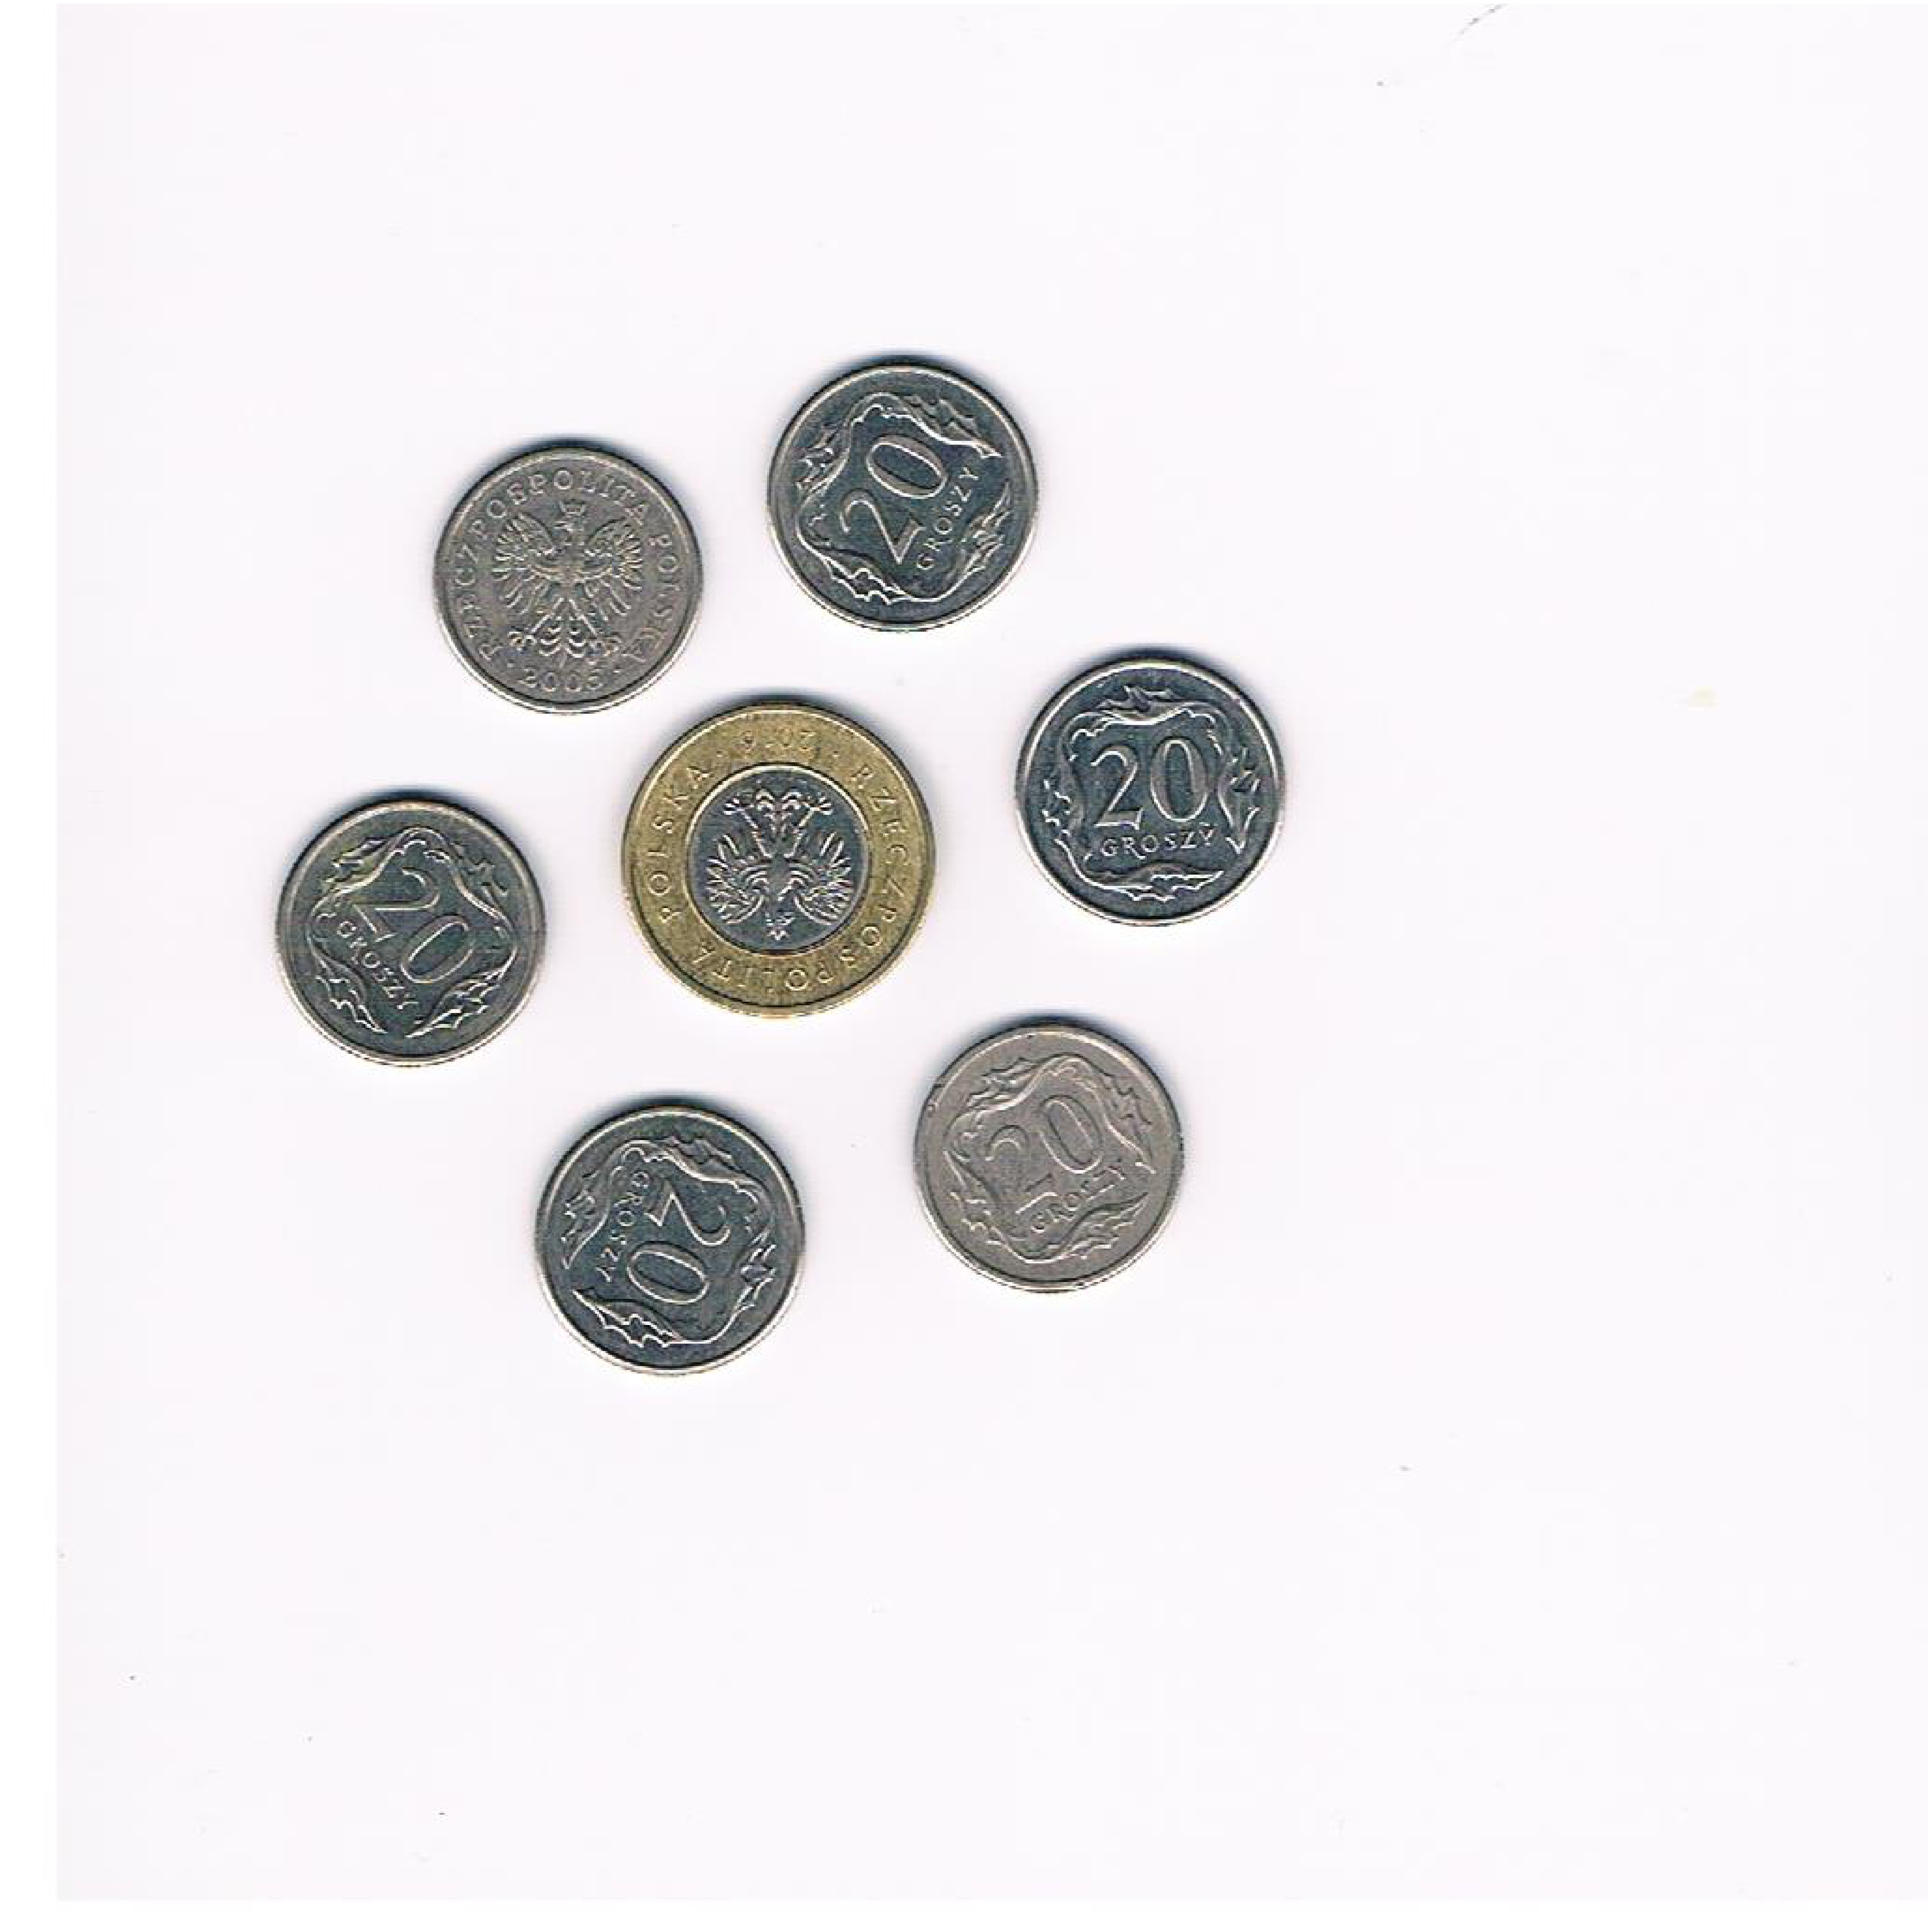

Start Segmentacji

Czas trwania:  38.38035798072815


In [3]:
img = 'k05.jpg'
image, im = import_image(img)
showImage(image)

len_y = len(im)
len_x = len(im[0])
index = [[0 for y in range(len_y)] for x in range(len_y)]


t0 = time.time()
print("Start Segmentacji")

tab, place = split_first(im, index, len(im[1]), len(im))

# print(place)


print("\nCzas trwania: ", time.time()-t0)

count_tab, image2 = countiong(tab, place, image) 
# print(count_tab)

# x = 0
# c_tab = []
# while x < place:
#     _, countours, hier = cv2.findContours(np.uint8(tab==x), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
#     for x in countours:
#         c_tab.append(x)
#     x += 1




# show_counting(count_tab)
coins_from_image = count_tab
coins = my_coins()
# show_counting(my_coins())

In [4]:
print("Obraz nr: ", img)
print("Ilosc obiektow na obrazie: "+ str(place-1))
print("Obiekty zajmuja powierzchnie obrazu w: "+ str(procent_object_image(count_tab, image)))
print("Wartosc monet na obrazie wynosi: "+ str(count_values(coins_from_image, coins) ))

for i in range(place):
    pts = getFigure(tab, i)
    if len(pts) < 44000:
        bb = computeBB(pts)
        feret = computeFeret(pts)
#         haralic = getHaralick(cog2(pts), c_tab[i])
        
        
        print("Obiect ",i)
        print("--> Liczba punktow: ", len(pts))
        print("--> Srodek ciezkosci: ", cog2(pts))
        print("--> Blair-Bliss: ", bb)
        print("--> Ferent: ",feret)



Obraz nr:  k05.jpg
Ilosc obiektow na obrazie: 7
Obiekty zajmuja powierzchnie obrazu w: 7%
Wartosc monet na obrazie wynosi: 3.2 zł
Obiect  1
--> Liczba punktow:  9741
--> Srodek ciezkosci:  [492.3101324299353, 212.075659583205]
--> Blair-Bliss:  0.9992792293660981
--> Ferent:  1.0377358490566038
Obiect  2
--> Liczba punktow:  9802
--> Srodek ciezkosci:  [613.0546827178127, 553.3796164048154]
--> Blair-Bliss:  0.9994864204145671
--> Ferent:  1.02803738317757
Obiect  3
--> Liczba punktow:  14811
--> Srodek ciezkosci:  [454.46877320910136, 408.6746337181824]
--> Blair-Bliss:  0.9991878506528886
--> Ferent:  1.037593984962406
Obiect  4
--> Liczba punktow:  9857
--> Srodek ciezkosci:  [656.6790098407223, 350.6494876737344]
--> Blair-Bliss:  0.9993112000828224
--> Ferent:  1.0373831775700935
Obiect  5
--> Liczba punktow:  9763
--> Srodek ciezkosci:  [417.15169517566324, 607.4958516849329]
--> Blair-Bliss:  0.9993766078259008
--> Ferent:  1.02803738317757
Obiect  6
--> Liczba punktow:  9776
--